In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from utils import print_metrics, train_model, count_parameters
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# use data augmentation
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.ToTensor()
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor()
])
# load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=test_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
# create data loaders
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_dataset.dataset.transform = train_transform
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


Number of trainable parameters: 20490
Epoch: 1/15 	 Train loss: 1.265 	 Train accuracy: 0.639 	 val loss: 0.935 	 val accuracy: 0.727
Epoch: 2/15 	 Train loss: 0.883 	 Train accuracy: 0.719 	 val loss: 0.794 	 val accuracy: 0.748
Epoch: 3/15 	 Train loss: 0.796 	 Train accuracy: 0.739 	 val loss: 0.748 	 val accuracy: 0.763
Epoch: 4/15 	 Train loss: 0.750 	 Train accuracy: 0.751 	 val loss: 0.703 	 val accuracy: 0.768
Epoch: 5/15 	 Train loss: 0.724 	 Train accuracy: 0.759 	 val loss: 0.692 	 val accuracy: 0.775
Epoch: 6/15 	 Train loss: 0.701 	 Train accuracy: 0.767 	 val loss: 0.666 	 val accuracy: 0.781
Epoch: 7/15 	 Train loss: 0.688 	 Train accuracy: 0.768 	 val loss: 0.657 	 val accuracy: 0.780
Epoch: 8/15 	 Train loss: 0.675 	 Train accuracy: 0.774 	 val loss: 0.639 	 val accuracy: 0.787
Epoch: 9/15 	 Train loss: 0.667 	 Train accuracy: 0.774 	 val loss: 0.623 	 val accuracy: 0.796
Epoch: 10/15 	 Train loss: 0.656 	 Train accuracy: 0.780 	 val loss: 0.644 	 val accuracy: 0.786
E

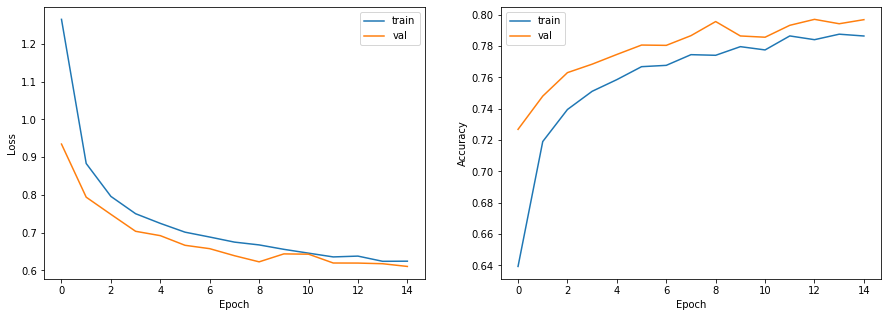

In [3]:
# load ResNet50 model using timm
model = timm.create_model('resnet50', pretrained=True)
# change the last layer to 10 classes
model.fc = nn.Linear(2048, 10)
# freeze all layers except the last layer
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
# move model to GPU
model = model.to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print("Number of trainable parameters: {}".format(count_parameters(model)))
# use train_model function to train the model
train_losses, val_losses, train_acc, val_acc = train_model(model, train_loader, val_loader, epochs=10, criterion=criterion, optimizer=optimizer, device=device)
# plot the training and validation loss and accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

              precision    recall  f1-score   support

    airplane       0.75      0.86      0.80      1000
  automobile       0.87      0.91      0.89      1000
        bird       0.80      0.71      0.75      1000
         cat       0.67      0.69      0.68      1000
        deer       0.83      0.72      0.77      1000
         dog       0.77      0.74      0.76      1000
        frog       0.84      0.89      0.86      1000
       horse       0.87      0.78      0.82      1000
        ship       0.86      0.87      0.87      1000
       truck       0.84      0.90      0.87      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



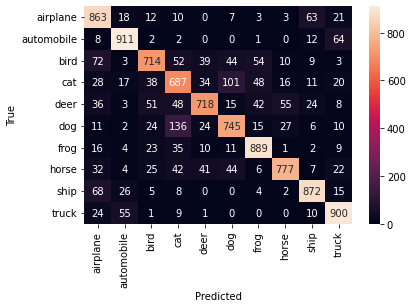

In [4]:
 # test the model on test data
print_metrics(model, test_loader, classes=test_dataset.classes, device=device)

In [5]:
# load ResNet18 model
student_model = timm.create_model('resnet18', pretrained=True)
# change the last layer to 10 classes
student_model.fc = nn.Linear(512, 10)
# move model to GPU
student_model = student_model.to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_model.parameters(), lr=1e-3)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\zolghadr/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth


In [6]:
# define a function to find the best alpha and T
def find_best_alpha_T(student_model, teacher_model, train_loader, test_loader, criterion, optimizer, epochs=10, T_list=[1, 10, 100], alpha_list=[0.1, 0.5, 0.9]):
    best_acc = 0
    best_alpha = 0
    best_T = 0
    for T in T_list:
        for alpha in alpha_list:
            print(f'alpha={alpha}, T={T}')
            student_model = timm.create_model('resnet18', pretrained=True)
            student_model.fc = nn.Linear(512, 10)
            student_model = student_model.to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(student_model.parameters(), lr=1e-3)
            train_loss, test_loss, train_acc, test_acc = train_model(student_model, train_loader, test_loader, epochs=epochs, criterion=criterion, optimizer=optimizer, device=device, teacher_model=model, T=T, alpha=alpha)
            if test_acc[-1] > best_acc:
                best_acc = test_acc[-1]
                best_alpha = alpha
                best_T = T
    return best_acc, best_alpha, best_T


In [7]:
# find the best alpha and T
best_acc, best_alpha, best_T = find_best_alpha_T(student_model, model, train_loader, val_loader, criterion, optimizer, epochs=4, T_list=[1, 10, 20], alpha_list=[0.1, 0.5, 0.9])

alpha=0.1, T=1
Epoch: 1/4 	 Train loss: 1.106 	 Train accuracy: 0.777 	 val loss: 1.031 	 val accuracy: 0.830
Epoch: 2/4 	 Train loss: 1.023 	 Train accuracy: 0.835 	 val loss: 1.043 	 val accuracy: 0.833
Epoch: 3/4 	 Train loss: 0.996 	 Train accuracy: 0.853 	 val loss: 1.016 	 val accuracy: 0.844
Epoch: 4/4 	 Train loss: 0.983 	 Train accuracy: 0.860 	 val loss: 0.983 	 val accuracy: 0.861
alpha=0.5, T=1
Epoch: 1/4 	 Train loss: 0.900 	 Train accuracy: 0.807 	 val loss: 0.826 	 val accuracy: 0.852
Epoch: 2/4 	 Train loss: 0.777 	 Train accuracy: 0.881 	 val loss: 0.826 	 val accuracy: 0.863
Epoch: 3/4 	 Train loss: 0.743 	 Train accuracy: 0.903 	 val loss: 0.749 	 val accuracy: 0.898
Epoch: 4/4 	 Train loss: 0.720 	 Train accuracy: 0.918 	 val loss: 0.762 	 val accuracy: 0.893
alpha=0.9, T=1
Epoch: 1/4 	 Train loss: 0.680 	 Train accuracy: 0.796 	 val loss: 0.698 	 val accuracy: 0.793
Epoch: 2/4 	 Train loss: 0.471 	 Train accuracy: 0.880 	 val loss: 0.484 	 val accuracy: 0.876
Epoch

In [8]:
# best_T, best_alpha = 10, 0.9 # From multiple experiments
print(f"Best T={best_T}, best alpha={best_alpha}")

Best T=10, best alpha=0.5


In [9]:
# train the student model with the best alpha and T
student_model = timm.create_model('resnet18', pretrained=True)
student_model.fc = nn.Linear(512, 10)
student_model = student_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_model.parameters(), lr=1e-3)
train_loss, test_loss, train_acc, test_acc = train_model(student_model, train_loader, val_loader, epochs=10, criterion=criterion, optimizer=optimizer, device=device, teacher_model=model, T=10, alpha=best_alpha)

Epoch: 1/15 	 Train loss: 113.776 	 Train accuracy: 0.822 	 val loss: 113.700 	 val accuracy: 0.861
Epoch: 2/15 	 Train loss: 113.617 	 Train accuracy: 0.890 	 val loss: 113.651 	 val accuracy: 0.876
Epoch: 3/15 	 Train loss: 113.578 	 Train accuracy: 0.909 	 val loss: 113.574 	 val accuracy: 0.892
Epoch: 4/15 	 Train loss: 113.542 	 Train accuracy: 0.923 	 val loss: 113.518 	 val accuracy: 0.916
Epoch: 5/15 	 Train loss: 113.518 	 Train accuracy: 0.935 	 val loss: 113.508 	 val accuracy: 0.909
Epoch: 6/15 	 Train loss: 113.503 	 Train accuracy: 0.941 	 val loss: 113.538 	 val accuracy: 0.913
Epoch: 7/15 	 Train loss: 113.486 	 Train accuracy: 0.949 	 val loss: 113.494 	 val accuracy: 0.925
Epoch: 8/15 	 Train loss: 113.471 	 Train accuracy: 0.955 	 val loss: 113.576 	 val accuracy: 0.888
Epoch: 9/15 	 Train loss: 113.449 	 Train accuracy: 0.960 	 val loss: 113.482 	 val accuracy: 0.923
Epoch: 10/15 	 Train loss: 113.450 	 Train accuracy: 0.963 	 val loss: 113.498 	 val accuracy: 0.928

              precision    recall  f1-score   support

    airplane       0.89      0.95      0.92      1000
  automobile       0.98      0.94      0.96      1000
        bird       0.98      0.85      0.91      1000
         cat       0.84      0.88      0.86      1000
        deer       0.96      0.92      0.94      1000
         dog       0.89      0.89      0.89      1000
        frog       0.92      0.98      0.95      1000
       horse       0.97      0.94      0.95      1000
        ship       0.93      0.97      0.95      1000
       truck       0.94      0.96      0.95      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



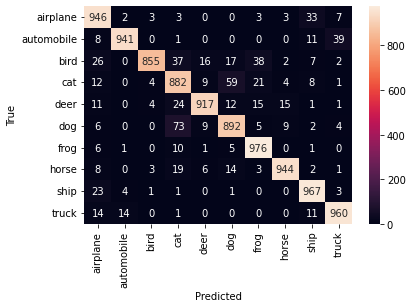

Number of trainable parameters: 11181642


In [10]:
# test the student model on test data
print_metrics(student_model, test_loader, classes=test_dataset.classes, device=device)
print(f'Number of trainable parameters: {count_parameters(student_model)}')

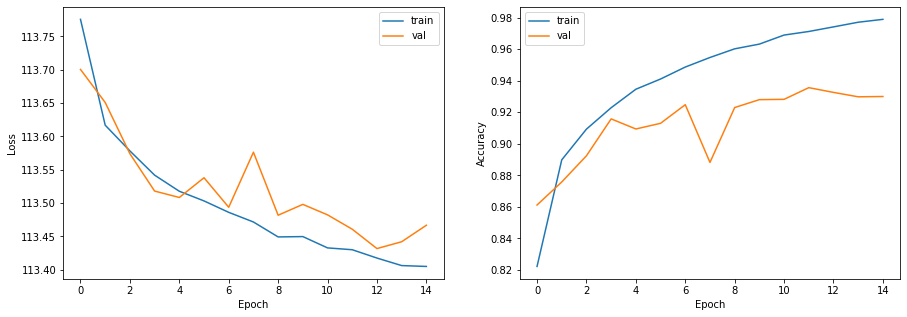

In [12]:
# plot the training and validation loss and accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
# fine-tune all of resnet18 model
model = timm.create_model('resnet18', pretrained=True)
model.fc = nn.Linear(512, 10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_loss, test_loss, train_acc, test_acc = train_model(model, train_loader, val_loader, epochs=10, criterion=criterion, optimizer=optimizer, device=device)

Epoch: 1/15 	 Train loss: 0.625 	 Train accuracy: 0.786 	 val loss: 0.524 	 val accuracy: 0.828
Epoch: 2/15 	 Train loss: 0.387 	 Train accuracy: 0.867 	 val loss: 0.436 	 val accuracy: 0.857
Epoch: 3/15 	 Train loss: 0.313 	 Train accuracy: 0.892 	 val loss: 0.353 	 val accuracy: 0.886
Epoch: 4/15 	 Train loss: 0.260 	 Train accuracy: 0.910 	 val loss: 0.339 	 val accuracy: 0.881
Epoch: 5/15 	 Train loss: 0.233 	 Train accuracy: 0.920 	 val loss: 0.276 	 val accuracy: 0.908
Epoch: 6/15 	 Train loss: 0.194 	 Train accuracy: 0.932 	 val loss: 0.291 	 val accuracy: 0.901
Epoch: 7/15 	 Train loss: 0.174 	 Train accuracy: 0.940 	 val loss: 0.276 	 val accuracy: 0.905
Epoch: 8/15 	 Train loss: 0.151 	 Train accuracy: 0.947 	 val loss: 0.271 	 val accuracy: 0.912
Epoch: 9/15 	 Train loss: 0.141 	 Train accuracy: 0.951 	 val loss: 0.266 	 val accuracy: 0.919
Epoch: 10/15 	 Train loss: 0.118 	 Train accuracy: 0.959 	 val loss: 0.253 	 val accuracy: 0.922
Epoch: 11/15 	 Train loss: 0.111 	 Trai

              precision    recall  f1-score   support

    airplane       0.84      0.95      0.89      1000
  automobile       0.96      0.94      0.95      1000
        bird       0.94      0.84      0.89      1000
         cat       0.71      0.88      0.79      1000
        deer       0.94      0.89      0.91      1000
         dog       0.86      0.79      0.82      1000
        frog       0.98      0.90      0.93      1000
       horse       0.97      0.89      0.93      1000
        ship       0.94      0.95      0.95      1000
       truck       0.92      0.96      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000



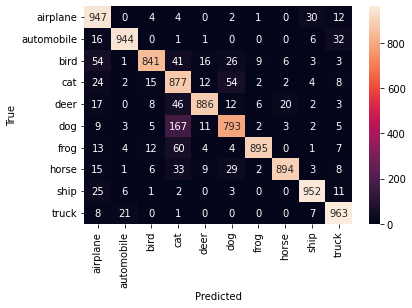

Number of trainable parameters: 11181642


In [14]:
# test the student model on test data
print_metrics(model, test_loader, classes=test_dataset.classes, device=device)
print(f'Number of trainable parameters: {count_parameters(student_model)}')

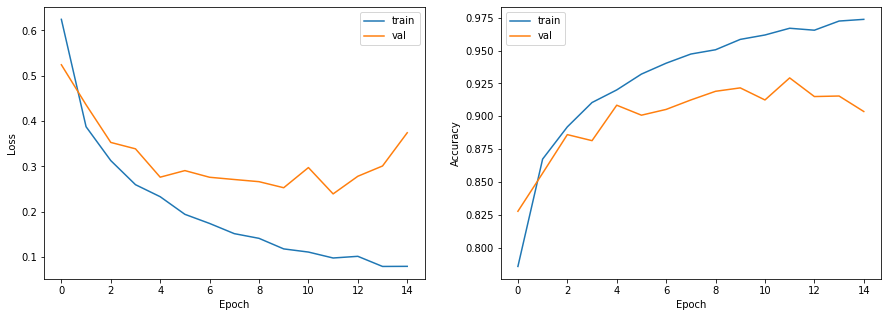

In [15]:
# plot the training and validation loss and accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# fine-tune all of resnet50 model
model = timm.create_model('resnet50', pretrained=True)
model.fc = nn.Linear(2048, 10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_loss, test_loss, train_acc, test_acc = train_model(model, train_loader, val_loader, epochs=10, criterion=criterion, optimizer=optimizer, device=device)


In [ ]:
# test the student model on test data
print_metrics(model, test_loader, classes=test_dataset.classes, device=device)
print(f'Number of trainable parameters: {count_parameters(student_model)}')

In [ ]:
# plot the training and validation loss and accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()